In [11]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import sympy as sp

In [34]:
N = 5 # Number of modes
a = qt.destroy(N)  # Photon annihilation operator
H = a.dag() * a  # Hamiltonian: number operator 
psi0 = qt.basis(N, 1)  # Initial state: 1 photon in the first mode
psi1 = qt.basis(N, 2)*4 # Initial state: 4 photons in the second mode
b = sp.symbols('b')  # Symbolic variable for the coherent state parameter
# qt.tensor(qt.basis(N, 0), qt.basis(N, 1))  # Tensor product of two states

(500, 500, 2) [-5. -5.]
(100, 100)


C:\Users\alexa\AppData\Local\Temp\ipykernel_26656\4194861446.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i,j] = Wigner2D(q[i,j], mu, varmat, detvar, invvar)


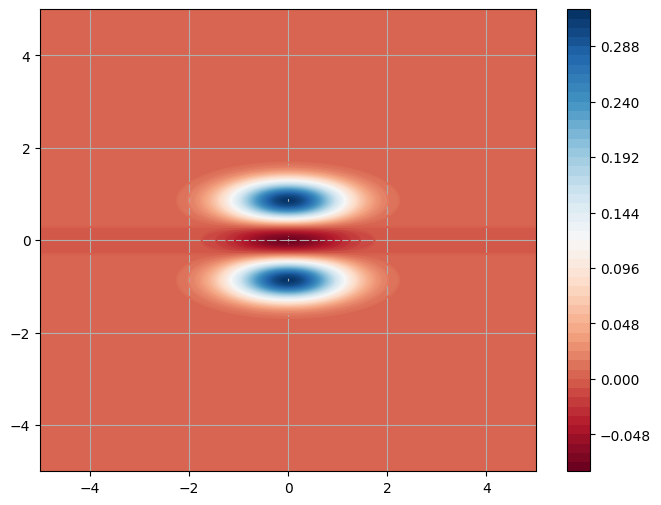

In [109]:
alpha = 1
psi2 = qt.coherent(N, alpha) + qt.coherent(N, -alpha)
r=0.5
k = 1
mu = np.sqrt(2) * alpha*np.exp(-r)
var = (1/2)*np.exp(-2*r)
varmat = (1/2)*np.array([[np.exp(-2*r), 0], [0, np.exp(2*r)]])
muvec = mu*np.array([1, 0])
muzvec = mu*np.array([0, 1j])

def Gaussian(x, mu, var):
    return (np.pi*var)**(1/4) * np.exp(-((x - mu)**2) / (2 * var))

def Gaussian2D(q, mu, var, detvar = None, invvar = None):
    if detvar is None:
        detvar = np.linalg.det(2*np.pi*var)
    if invvar is None:
        invvar = np.linalg.inv(var)
    else: 
        pass
    return 1/(np.sqrt(detvar)) * np.exp(-((q - mu).T) @ invvar @ ((q - mu).T))

grid = 500
x = np.linspace(-5, 5, grid)
p = np.linspace(-5, 5, grid)
q = np.array(np.meshgrid(x, p)).T
X, P = np.meshgrid(x, p)
print(q.shape, q[0,0])
print(Q.shape)


def Wigner2D(q, mu, varmat, detvar, invvar):
    muvec = mu*np.array([1, 0])
    muzvec = mu*np.array([0, 1j])
    G1 = Gaussian2D(q, muvec, varmat, detvar, invvar)
    G2 = (-1)**k*np.exp(-2*alpha**2)*Gaussian2D(q, muzvec, varmat, detvar, invvar)
    G3 = (-1)**k*np.exp(-2*alpha**2)*Gaussian2D(q, -muzvec, varmat, detvar, invvar)
    G4 = Gaussian2D(q, -muvec, varmat, detvar, invvar)
    return G1 + G2 + G3 + G4

def build_Wigner2D(mu, varmat):
    detvar = np.linalg.det(2*np.pi*varmat)
    invvar = np.linalg.inv(varmat)
    Q = np.zeros((grid, grid))
    for i in range(grid):
        for j in range(grid):
            Q[i,j] = Wigner2D(q[i,j], mu, varmat, detvar, invvar)
    return Q


"""
S = qt.squeeze(N, r)
psiS = S @ psi2
display(psiS, psi2)
rho_S = psiS * psiS.dag()
rho_Sm = S @ psi2 @ psi2.dag() @ S.dag()
display(rho_S, rho_Sm)
"""

vals = build_Wigner2D(muvec, varmat)
fig, ax = plt.subplots(figsize=(8, 6))
fig.colorbar(ax.contourf(X, P, vals, levels=50, cmap='RdBu'), ax=ax)
ax.contour(X,P,vals, levels=50, cmap='RdBu')
ax.grid()

In [3]:
kappa = 1.0/0.129
nth = 0.063
# collapse operators
c_ops = []
c_ops.append(np.sqrt(kappa * (nth + 1)) * a)  # decay
c_ops.append(np.sqrt(kappa * nth) * a.dag())  # decay

In [4]:
ntraj = [1, 5, 15, 904]  # number of MC trajectories
mc = []  # MC results
tlist = np.linspace(0, 0.8, 100)

# Solve using MCSolve for different ntraj
for n in ntraj:
    result = qt.mcsolve(H, psi0, tlist, c_ops, [a.dag() * a], ntraj=n)
    mc.append(result)
me = qt.mesolve(H, psi0, tlist, c_ops, [a.dag() * a])

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.00s
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
100.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.02s
13.3%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.01s. Est. time left: 00:00:00:00
33.3%. Run time:   0.01s. Est. time left: 00:00:00:00
40.0%. Run time:   0.01s. Est. time left: 00:00:00:00
53.3%. Run time:   0.02s. Est. time left: 00:00:00:00
60.0%. Run time:   0.02s. Est. time left: 00:00:00:00
73.3%. Run time:   0.03s. Est. time left: 00:00:00:00
80.0%. Run time:   0.03s. Est. time left: 00:00:00:00
93.3%. Run time:   0.03s. Est. time left: 00:00:00:00
100.0%. Run time:   0.04s. Est. time left: 00:00:00:00


c:\Users\alexa\10387_SCiQIS\10387_venv\.venv\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Total run time:   0.04s
10.1%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.30s. Est. time left: 00:00:00:01
30.1%. Run time:   0.43s. Est. time left: 00:00:00:00
40.0%. Run time:   0.56s. Est. time left: 00:00:00:00
50.0%. Run time:   0.69s. Est. time left: 00:00:00:00
60.1%. Run time:   0.82s. Est. time left: 00:00:00:00
70.0%. Run time:   0.94s. Est. time left: 00:00:00:00
80.1%. Run time:   1.07s. Est. time left: 00:00:00:00
90.0%. Run time:   1.20s. Est. time left: 00:00:00:00
100.0%. Run time:   1.33s. Est. time left: 00:00:00:00
Total run time:   1.33s


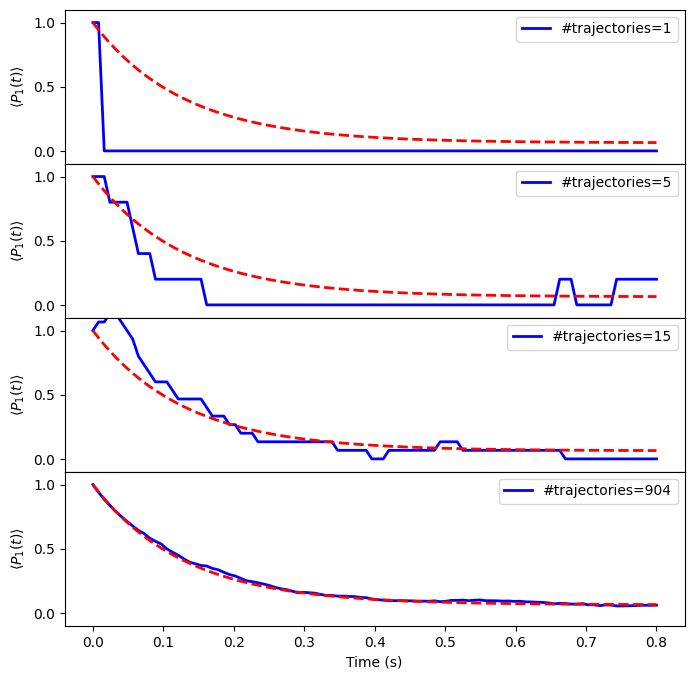

In [5]:
fig = plt.figure(figsize=(8, 8), frameon=True)
plt.subplots_adjust(hspace=0.0)

for i in range(len(ntraj)):
    ax = plt.subplot(4, 1, i + 1)
    ax.plot(
        tlist, mc[i].expect[0], "b", lw=2,
        label="#trajectories={}".format(ntraj[i])
    )
    ax.plot(tlist, me.expect[0], "r--", lw=2)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_ylabel(r"$\langle P_{1}(t)\rangle$")
    ax.legend()

ax.set_xlabel(r"Time (s)");

In [10]:
psi = qt.ket('01')
print(psi)

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]
